<a href="https://colab.research.google.com/github/dkm4/Complete-Image-classification-ConvNet-/blob/main/Complete_Image_classification(ConvNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_location = "/content/drive/MyDrive/upwork/image_classification_dataset"
print(f"Dataset location is {dataset_location}")

Dataset location is /content/drive/MyDrive/upwork/image_classification_dataset


# Imports

In [ ]:
import os
import glob
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
print(torch.__version__)
print(torchvision.__version__)

2.1.0+cu121
0.16.0+cu121


In [ ]:
train_data_location = os.path.join(dataset_location,  'train')
test_data_location = os.path.join(dataset_location, 'test')
print(f"Train data location is {train_data_location}")
print(f"Test data location is {test_data_location}")

Train data location is /content/drive/MyDrive/upwork/image_classification_dataset/train
Test data location is /content/drive/MyDrive/upwork/image_classification_dataset/test


# Setup the device

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"My device is {device}")

My device is cuda


# Build datasets and Dataloaders

In [ ]:
def find_classes(data_location):
  classes = sorted(os.listdir(data_location))
  class_to_idx = {cls_name:i for i, cls_name in enumerate(classes)}
  return classes, class_to_idx

def give_me_all_images_path(data_location):
  return glob.glob(os.path.join(data_location, '*', '*.*'), recursive=True)

def pathToClass(path):
  dirname = os.path.dirname(path)
  return os.path.basename(dirname)



In [ ]:
class ImageFolderCustom(Dataset):
  def __init__(self, dataset_path, transform):
    self.dataset_path = dataset_path
    self.transform    = transform
    self.classes, self.class_to_idx = find_classes(dataset_path)
    self.paths = give_me_all_images_path(dataset_path)

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    path = self.paths[idx]
    img = Image.open(path)
    my_class = pathToClass(path)
    class_label = self.class_to_idx[my_class]
    if self.transform:
      return self.transform(img), class_label
    else:
      return img, class_label

In [ ]:
#pytorch:you can give me a folder location and I can create dataset for you
from torchvision import datasets
train_transform = transforms.Compose([
  # transforms.RandomRotation(),
        transforms.RandomHorizontalFlip(0.5),
            # Random vertical flip
        transforms.RandomVerticalFlip(0.3),
       transforms.ToTensor(),
 ])
test_transform = transforms.Compose([
     transforms.ToTensor(),
 ])


BATCH_SIZE=32
train_data = ImageFolderCustom(train_data_location, transform=train_transform)
test_data = ImageFolderCustom(test_data_location, transform=test_transform)
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader  = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

# Visualize dataset

In [ ]:
print(len(train_data))
print(len(test_data))

225
75


In [ ]:
class_names = train_data.classes
print(class_names)

['pizza', 'steak', 'sushi']


In [ ]:
class_dict = train_data.class_to_idx
print(class_dict)

{'pizza': 0, 'steak': 1, 'sushi': 2}


Image shape is torch.Size([3, 128, 128])
Label is 0
Original image:torch.Size([3, 128, 128])
Permuted image:torch.Size([128, 128, 3])


Text(0.5, 1.0, 'pizza')

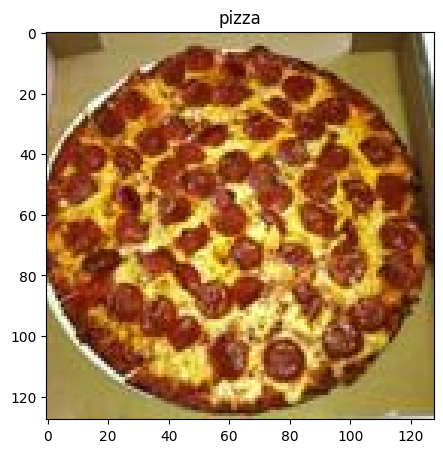

In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image shape is {img.shape}")
print(f"Label is {label}")
img_permute = img.permute(1, 2, 0)
print(f"Original image:{img.shape}")
print(f"Permuted image:{img_permute.shape}")
plt.figure(figsize=(5, 6))
plt.imshow(img_permute)
plt.title(class_names[label])

In [ ]:
img, label = next(iter(train_dataloader))
print(img.shape)
print(type(label))
print(label.shape)
print(label)

torch.Size([32, 3, 128, 128])
<class 'torch.Tensor'>
torch.Size([32])
tensor([1, 2, 0, 0, 1, 2, 1, 0, 2, 1, 2, 1, 1, 0, 1, 0, 2, 2, 1, 0, 0, 0, 0, 1,
        1, 2, 2, 1, 2, 1, 0, 1])


In [ ]:
for batch_idx, i in enumerate(test_dataloader):
  print(f"batch:{batch_idx+1} and number of points are {len(i[0])}")

batch:1 and number of points are 32
batch:2 and number of points are 32
batch:3 and number of points are 11


In [ ]:
N, C, H, W = img.shape
input_len = C*H*W
print(input_len)

49152


# Build Neural network Architecture

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class ConvNN(nn.Module):
  def __init__(self, in_channels=3, out_channels=10, hidden_channels=10):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
    )


    self.fcnn = nn.Sequential(
        nn.Flatten(),
        nn.Linear(30*30*32, out_channels)
    )

  def forward(self, x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    # x = self.conv_block3(x)
    x = self.fcnn(x)
    return x

model = ConvNN(in_channels=3, out_channels=len(class_names))

# Visualize the forward pass of neural network

In [ ]:
random_tensor = torch.rand((32, C, H, W))
print(f"input tensor shape is {random_tensor.shape}")
print(f"output tensor shape is {model(random_tensor).shape}")

input tensor shape is torch.Size([32, 3, 128, 128])
output tensor shape is torch.Size([32, 3])


# Loss function and Optimizer

In [ ]:
loss_fn   = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)

# Define various utility functions for training

In [ ]:
def acc_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/ len(y_true))*100.0
  return acc

def train_step(model, training_dataloader, loss_fn, optimizer, device):
  train_loss = 0
  train_acc = 0
  model.train()
  for batch_idx, item in enumerate(training_dataloader):
    X_batch, y_batch = item
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)
    model.to(device)
    logits = model(X_batch)
    training_loss = loss_fn(logits, y_batch)
    train_loss += training_loss
    y_preds = torch.softmax(logits, dim=1).argmax(dim=1)
    training_acc = acc_fn(y_batch, y_preds)
    train_acc+=training_acc
    optimizer.zero_grad()
    training_loss.backward()
    optimizer.step()
  print(f"My training loss: {train_loss/len(training_dataloader)} Training acc:{train_acc/len(training_dataloader)}")


def test_step(model, testing_dataloader, loss_fn, device):
  test_loss = 0
  test_acc  = 0
  model.eval()
  with torch.no_grad():
    for batch_idx, item in enumerate(testing_dataloader):
      X_batch, y_batch = item
      X_batch = X_batch.to(device)
      y_batch = y_batch.to(device)
      model.to(device)
      logits = model(X_batch)
      testing_loss = loss_fn(logits, y_batch)
      test_loss += testing_loss
      y_preds = torch.softmax(logits, dim=1).argmax(dim=1)
      testing_acc = acc_fn(y_batch, y_preds)
      test_acc+=testing_acc
  print(f"My testing loss: {test_loss/len(testing_dataloader)} Testing acc:{test_acc/len(testing_dataloader)}")

# Train the Model

In [ ]:
from tqdm.auto import tqdm
epochs = 500
for epoch in tqdm(range(epochs)):
  print(f"My epoch {epoch}\n-----------")
  train_step(model, train_dataloader, loss_fn, optimizer, device)
  test_step(model, test_dataloader, loss_fn, device)
  print("\n\n")

  0%|          | 0/500 [00:00<?, ?it/s]

My epoch 0
-----------
My training loss: 1.1397228240966797 Training acc:30.46875
My testing loss: 1.0743378400802612 Testing acc:39.109848484848484



My epoch 1
-----------
My training loss: 1.0037983655929565 Training acc:54.6875
My testing loss: 1.1408004760742188 Testing acc:29.166666666666668



My epoch 2
-----------
My training loss: 0.9884362816810608 Training acc:46.875
My testing loss: 1.0659818649291992 Testing acc:33.333333333333336



My epoch 3
-----------
My training loss: 1.0217928886413574 Training acc:40.234375
My testing loss: 0.9879149794578552 Testing acc:51.325757575757585



My epoch 4
-----------
My training loss: 0.9797415733337402 Training acc:51.171875
My testing loss: 1.0652987957000732 Testing acc:34.28030303030303



My epoch 5
-----------
My training loss: 0.8593178987503052 Training acc:64.453125
My testing loss: 0.9278219938278198 Testing acc:58.428030303030305



My epoch 6
-----------
My training loss: 0.9438602924346924 Training acc:47.65625
My test

KeyboardInterrupt: 